voronoi.ipynb

Discussion: This Jupyter notebook investigates 1D and 2D Voronoi diagrams

Licensing: This code is distributed under the GNU LGPL license.
    
Modified: 23 October 2016

Author: John Burkardt, Lukas Bystricky

In [1]:
# Import necessary libraries and set plot option
%matplotlib
%config InlineBackend.figure_format = 'png'
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.spatial as spatial

Using matplotlib backend: agg


# Voronoi

In this module we will investigate Voronoi diagrams in 1D and 2D.

We are given a geometric region R (the whole line or an interval, the plane, 
a rectangle, circle or other shape).

We are also given a set G of "generators", points inside the region.

The Voronoi diagram simply assigns every point x in R to the nearest
generator g in G, dividing R into Voronoi subregions.

In [25]:
## A 1D finite region R.
#
#  Let R be [0,1], and define G = [ 1/5, 2/5, 3/5, 4/5 ]
#
g = np.array ( [ 1.0/5.0, 2.0/5.0, 3.0/5.0, 4.0/5.0] )
#
#  Compute the length and centroid of each subregion.
#
#  Note that:
#    subregion 0 extends from 0 to midway between 1/5 and 2/5.
#    subregion 1 extends from midway between 1/5 and 2/5, to midway between 2/5 and 3/5.
#
length = np.zeros ( 4 )
centroid = np.zeros ( 4 )
right = np.zeros ( 4 )
left = np.zeros ( 4 )
for i in range ( 0, 4 ):
  if ( i == 0 ):
    left[i] = 0.0
  else:
    left[i] = ( g[i-1] + g[i] ) / 2.0
  if ( i < 3 ):
    right[i] = ( g[i] + g[i+1] ) / 2.0
  else:
    right[i] = 1.0
  length[i] = right[i] - left[i]
  centroid[i] = ( right[i] + left[i] ) / 2.0
#
#  The "energy" of the i-th Voronoi subregion pi is the integral
#  ei = Integral(pi) ( x-gi )^2 dx
#  Compute the energy for each region.
#
energy = np.zeros ( 4 )
for i in range ( 0, 4 ):
  energy[i] = ( ( right[i] - g[i] ) ** 3 - ( left[i] - g[i] ) ** 3 ) / 3.0
#
#  Print i, g[i], left[i], right[i], centroid[i], length[i], energy[i]
#
print ( '' )
print ( ' I            G[I]          Left[I]       Right[I]     Centroid[I]       Length[I]       Energy[I]' )
for i in range ( 0, 4 ):
  print ( '%2d  %14.6f  %14.6f  %14.6f  %14.6f  %14.6f  %14.6f' \
  % ( i, g[i], left[i], right[i], centroid[i], length[i], energy[i] ) )

(0, 0.0, 0.30000000000000004, 0.15000000000000002)
(1, 0.30000000000000004, 0.5, 0.40000000000000002)
(2, 0.5, 0.69999999999999996, 0.59999999999999998)
(3, 0.69999999999999996, 1.0, 0.84999999999999998)

 I            G[I]          Left[I]       Right[I]     Centroid[I]       Length[I]       Energy[I]
 0        0.200000        0.000000        0.300000        0.150000        0.300000        0.003000
 1        0.400000        0.300000        0.500000        0.400000        0.200000        0.000667
 2        0.600000        0.500000        0.700000        0.600000        0.200000        0.000667
 3        0.800000        0.700000        1.000000        0.850000        0.300000        0.003000


In [26]:
# Energy Reduction
#
#  We will see later that reducing the total energy is an important guide
#  for improving the smoothness of a point distribution.
#
#  Notice the G[0] and G[3] are not the same as the centroids of their subregions.
#
#  Replace G[0] and G[3] by their centroids, and recompute the energies.
#
#  Expect the total energy to go down.
#
g[0] = centroid[0]
g[3] = centroid[3]

for i in range ( 0, 4 ):
  energy[i] = ( ( right[i] - g[i] ) ** 3 - ( left[i] - g[i] ) ** 3 ) / 3.0
#
#  Print i, g[i], left[i], right[i], centroid[i], length[i], energy[i]
#
print ( '' )
print ( ' I            G[I]          Left[I]       Right[I]     Centroid[I]       Length[I]       Energy[I]' )
for i in range ( 0, 4 ):
  print ( '%2d  %14.6f  %14.6f  %14.6f  %14.6f  %14.6f  %14.6f' \
  % ( i, g[i], left[i], right[i], centroid[i], length[i], energy[i] ) )


 I            G[I]          Left[I]       Right[I]     Centroid[I]       Length[I]       Energy[I]
 0        0.150000        0.000000        0.300000        0.150000        0.300000        0.002250
 1        0.400000        0.300000        0.500000        0.400000        0.200000        0.000667
 2        0.600000        0.500000        0.700000        0.600000        0.200000        0.000667
 3        0.850000        0.700000        1.000000        0.850000        0.300000        0.002250


In [31]:
#  Sampling estimates
#
#  Geometry in 1D is easy.  But let's pretend it's hard.  It turns out we can estimate
#  the values of length, centroid and energy for each subregion by sampling.
#
#  If we can generate n uniform random samples of the area, and neari is the number of
#  those samples xj closest to generator gi, and l is the length of our region, then:
#
#  estimated length of subregion i: li = l * ( neari / n )
#  estimated centroid:              ci = sum ( xj ) / neari
#  estimated energy:                ei = li * sum ( xj - gi )**2 / neari
#
#  Do these estimates for our 1D problem, using N = 1000.
#
#  Don't forget to restore the original values of g[0] and g[3]!
#
g[0] = 0.2
g[3] = 0.8

n = 1000
x = np.random.random ( n )

centroid = np.zeros ( 4 )
length = np.zeros ( 4 )
energy = np.zeros ( 4 )
near = np.zeros ( 4 )

for j in range ( 0, n ):
  i = ( np.abs ( g - x[j] ) ).argmin ( )
  near[i] = near[i] + 1
  centroid[i] = centroid[i] + x[j]
  energy[i] = energy[i] + ( g[i] - x[j] ) ** 2

for i in range ( 0, 4 ):
  length[i] = 1.0 * float ( near[i] ) / float ( n )
  centroid[i] = centroid[i] / float ( near[i] )
  energy[i] = length[i] * energy[i] / float ( near[i] )
# 
#  Print i, g[i], left[i], right[i], centroid[i], length[i], energy[i]
#
print ( '' )
print ( ' I            G[I]          Left[I]       Right[I]     Centroid[I]       Length[I]       Energy[I]' )
for i in range ( 0, 4 ):
  print ( '%2d  %14.6f  %14.6f  %14.6f  %14.6f  %14.6f  %14.6f' \
  % ( i, g[i], left[i], right[i], centroid[i], length[i], energy[i] ) )


 I            G[I]          Left[I]       Right[I]     Centroid[I]       Length[I]       Energy[I]
 0        0.200000        0.000000        0.300000        0.144178        0.320000        0.003303
 1        0.400000        0.300000        0.500000        0.404088        0.190000        0.000649
 2        0.600000        0.500000        0.700000        0.598942        0.200000        0.000724
 3        0.800000        0.700000        1.000000        0.850480        0.290000        0.002969


[[ 0.2  0.2]
 [ 0.4  0.2]
 [ 0.6  0.2]
 [ 0.8  0.2]
 [ 0.2  0.4]
 [ 0.4  0.4]
 [ 0.6  0.4]
 [ 0.8  0.4]
 [ 0.2  0.6]
 [ 0.4  0.6]
 [ 0.6  0.6]
 [ 0.8  0.6]
 [ 0.2  0.8]
 [ 0.4  0.8]
 [ 0.6  0.8]
 [ 0.8  0.8]]


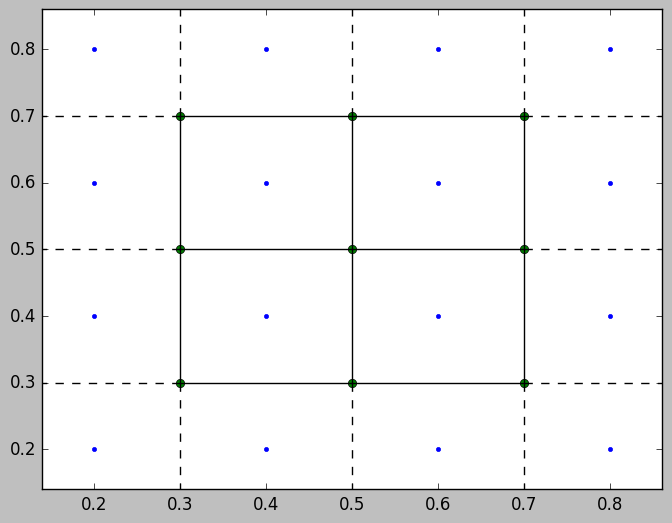

In [49]:
## Exact 2D Voronoi diagrams
#
#  Given a set of points in 2D, we can compute the exact 2D 
#  Voronoi diagram.  A plot of the diagram shows the boundaries
#  defining each Voronoi polygon.  Some of the lines seem to
#  go off to infinity, and they really do.
#
#  We saw in the 2D geometry notebook that we could define a set of
#  points, and then compute the Voronoi diagram using the 
#  vor=scipy.spatial.Voronoi() command, followed by the 
#  spatial.voronoi_plot_2d(vor) command to actually see the diagram.
#
#  If we use a very regular set of points, we may be able to guess what
#  the Voronoi diagram looks like.  So make a tensor product of the points
#  we called "g" for the 1d problem.
#
#  We do this using the numpy.meshgrid() command:
#    X, Y = numpy.meshgrid ( g, g )
#
g = np.array ( [ 1.0/5.0, 2.0/5.0, 3.0/5.0, 4.0/5.0] )

X, Y = np.meshgrid ( g, g )
#
#  Unfortunately, the Voronoi command doesn't want two matrices of X and Y coordinates.
#  It wants a single Nx2 array, with each row containing an (X,Y) pair.
#  Here's one way to make Voronoi happy:
#
XY = np.zeros ( [ 16, 2 ] )
XY[:,0] = np.ndarray.flatten ( X )
XY[:,1] = np.ndarray.flatten ( Y )
#
#  Now compute the Voronoi diagram.
#
vor = spatial.Voronoi ( XY )
#
#  Now plot the Voronoi diagram. Note that the plotting command arbitrarily chooses 
#  the plot range, so it shows the nonunit square [0.1,0.9]x[0.1,0.9], which may give 
#  the false impression that the Voronoi polygons all have the same size, and
#  the generators g are the centroids of their region.  However, the
#  layer of Voronoi subregions along the boundary are not the same shape
#  as those away from the boundary, and their generators are not at the
#  centers of their subregions!  We will demonstrate this in a minute.
#
spatial.voronoi_plot_2d ( vor )


In [59]:
## Approximate 2D Voronoi diagrams by sampling
#
#  Let's consider our 2D problem, and try to analyze it using sampling, to get
#  the area, centroid, and energy of each Voronoi subregion.
#
#  We are restricting our attention to the unit square, so we can easily compute
#  a 10000x2 array of random values by calling np.random.rand ( 10000, 2 )
#
g = np.array ( [ 1.0/5.0, 2.0/5.0, 3.0/5.0, 4.0/5.0] )

GX, GY = np.meshgrid ( g, g )
G = np.zeros ( [ 16, 2 ] )
G[:,0] = np.ndarray.flatten ( GX )
G[:,1] = np.ndarray.flatten ( GY )

centroid = np.zeros ( [ 16, 2 ] )
area = np.zeros ( 16 )
energy = np.zeros ( 16 )
near = np.zeros ( 16 )

n = 10000
XY = np.random.rand ( n, 2 )

def nearest ( G, xy ):
  idx = -1
  dmin = np.Inf
  for i in range ( 0, 16 ):
    d = np.linalg.norm ( G[i,:] - xy[:] )    
    if ( d < dmin ):
      idx = i
      dmin = d
  return idx  

for j in range ( 0, n ):
  i = nearest ( G, XY[j,:] )
  near[i] = near[i] + 1
  centroid[i,:] = centroid[i,:] + XY[j]
  energy[i] = energy[i] + ( G[i,0] - XY[j,0] ) ** 2 + ( G[i,1] - XY[j,1] ) ** 2

print ( near )
    
for i in range ( 0, 16 ):
  area[i] = 1.0 * float ( near[i] ) / float ( n )
  centroid[i,:] = centroid[i,:] / float ( near[i] )
  energy[i] = area[i] * energy[i] / float ( near[i] )
# 
#  Print i, g[i], centroid[i,:], area[i], energy[i]
#
print ( '' )
print ( ' I            G[I,0]     G[I,1]          Centroid[I,0]  Centroid[I,1]       Area[I]       Energy[I]' )
for i in range ( 0, 16 ):
  print ( '%2d  %14.6f  %14.6f  %14.6f  %14.6f  %14.6f  %14.6f' \
  % ( i, G[i,0], G[i,1], centroid[i,0], centroid[i,1], area[i], energy[i] ) )

[ 862.  612.  599.  886.  595.  421.  422.  599.  602.  404.  424.  583.
  878.  578.  628.  907.]

 I            G[I,0]     G[I,1]          Centroid[I,0]  Centroid[I,1]       Area[I]       Energy[I]
 0        0.200000        0.200000        0.157865        0.154298        0.086200        0.001601
 1        0.400000        0.200000        0.395086        0.153764        0.061200        0.000765
 2        0.600000        0.200000        0.601660        0.148880        0.059900        0.000817
 3        0.800000        0.200000        0.849418        0.147855        0.088600        0.001764
 4        0.200000        0.400000        0.149250        0.401418        0.059500        0.000767
 5        0.400000        0.400000        0.396536        0.397369        0.042100        0.000273
 6        0.600000        0.400000        0.601648        0.402212        0.042200        0.000290
 7        0.800000        0.400000        0.853284        0.404502        0.059900        0.000823
 8      

## Comments##

There are four generators in corners, such as (0.2,0.2).  
Our results suggest that these generators have energies around 0.0017,
and areas around 0.09.

There are 8 generators away from corners, but near boundaries.
Our results suggest all these generators have energies around 0.0007,
and areas around 0.06.

Finally, there are four generators tucked in the middle of the region,
away from the boundaries.  They have energies around 0.00028 (the least),
and areas around 0.04.

Notice that the generators near boundaries are not close to the centroids
we compute, but the four interior generators are.

Our goal, later on, will be to automatically adjust the points G so that
each subregion has about the same area, and is very close to the centroid...
